In [34]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils, Lapse_model
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
from scipy import stats
import scipy.optimize as opt


#warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Dataset name
DS_name = '6OHDA_Apr2020'

'''
This dataset has already been pre-processed, eliminating initial trials for example
'''

'\nThis dataset has already been pre-processed, eliminating initial trials for example\n'

In [36]:
# path to the dataset
data_directory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/' + DS_name + '_Analysis/'
# dataframe name
df_name = DS_name + '_dataframe.pkl'

# Read the dataframe
df_to_plot = pd.read_pickle(data_directory + df_name)

In [37]:
# Select only the auditory for now
df_to_plot = df_to_plot[df_to_plot.Protocol == 'Auditory']

In [38]:
# bin trials every 200
df_to_plot["TrialIndexBinned200"] = (df_to_plot.CumulativeTrialNumberByProtocol * 10 // 2000) * 200

In [39]:
# bin trials every 30
df_to_plot["TrialIndexBinned30"] = (df_to_plot.CumulativeTrialNumberByProtocol * 10 // 300) * 30

In [40]:
df_to_plot.columns

Index(['AnimalID', 'CenterPortDuration', 'Contingency',
       'CumulativePerformance', 'ExperimentalGroup', 'FirstPoke',
       'FirstPokeCorrect', 'FullSessionTime', 'Muscimol', 'OptoStim',
       'Outcomes', 'PreviousChoice', 'Protocol', 'ResponseTime',
       'RewardAmount', 'RewardChange', 'RewardChangeBlock', 'RightBias',
       'SessionTime', 'Stimulation', 'SwitchSide', 'TrialEvents',
       'TrialHighPerc', 'TrialIndex', 'TrialSequence', 'TrialSide',
       'TrialStartTimestamp', 'TrialStates', 'SessionID',
       'CumulativeTrialNumber', 'CumulativeTrialNumberByProtocol',
       'CurrentPastPerformance20', 'CurrentPastPerformance100',
       'NoOfCenterPokes', 'MiddleWaitTime', 'TrialInitiationTime',
       'TrialsSpeed', 'PrevTrialSuccess', 'TrialIndexBinned200',
       'TrialIndexBinned30'],
      dtype='object')

In [41]:
# show a summary of the dataset
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).size()

AnimalID  ExperimentalGroup  Protocol
C01       CortexBuffer       Auditory    4879
C02       CortexBuffer       Auditory    4901
C03       CortexBuffer       Auditory    4879
C04       6OHDAtail          Auditory    4857
C05       6OHDAtail          Auditory    4835
C06       6OHDAtail          Auditory    4835
N06       6OHDAtail          Auditory    4835
PV01      6OHDAtail          Auditory    4868
PV02      6OHDAtail          Auditory    4912
PV03      6OHDAtail          Auditory    4890
PV04      6OHDAtail          Auditory    4890
PV05      6OHDAtail          Auditory    4901
PV06      6OHDAtail          Auditory    4879
PV08      6OHDAtail          Auditory    4879
SomFlp04  CortexBuffer       Auditory    4810
SomFlp06  CortexBuffer       Auditory    4857
SomFlp07  6OHDAtail          Auditory    4868
SomFlp08  6OHDAtail          Auditory    4890
SomFlp09  6OHDAtail          Auditory    4890
dtype: int64

In [42]:
df_to_plot.groupby(['AnimalID', 'ExperimentalGroup', 'Protocol']).max()['CumulativeTrialNumberByProtocol']

AnimalID  ExperimentalGroup  Protocol
C01       CortexBuffer       Auditory    5000.0
C02       CortexBuffer       Auditory    5000.0
C03       CortexBuffer       Auditory    5000.0
C04       6OHDAtail          Auditory    5000.0
C05       6OHDAtail          Auditory    5000.0
C06       6OHDAtail          Auditory    5000.0
N06       6OHDAtail          Auditory    5000.0
PV01      6OHDAtail          Auditory    5000.0
PV02      6OHDAtail          Auditory    5000.0
PV03      6OHDAtail          Auditory    5000.0
PV04      6OHDAtail          Auditory    5000.0
PV05      6OHDAtail          Auditory    5000.0
PV06      6OHDAtail          Auditory    5000.0
PV08      6OHDAtail          Auditory    5000.0
SomFlp04  CortexBuffer       Auditory    4953.0
SomFlp06  CortexBuffer       Auditory    5000.0
SomFlp07  6OHDAtail          Auditory    5000.0
SomFlp08  6OHDAtail          Auditory    5000.0
SomFlp09  6OHDAtail          Auditory    5000.0
Name: CumulativeTrialNumberByProtocol, dtype: floa

In [43]:
df_to_plot[df_to_plot.AnimalID=='C01'].dtypes

AnimalID                                   object
CenterPortDuration                        float64
Contingency                                 int64
CumulativePerformance                     float64
ExperimentalGroup                          object
FirstPoke                                 float64
FirstPokeCorrect                          float64
FullSessionTime                    datetime64[ns]
Muscimol                                   object
OptoStim                                  float64
Outcomes                                  float64
PreviousChoice                            float64
Protocol                                   object
ResponseTime                              float64
RewardAmount                                int64
RewardChange                               object
RewardChangeBlock                         float64
RightBias                                 float64
SessionTime                                object
Stimulation                                object


#### Make figure-ready plots

Progress: [####################] 100.0%


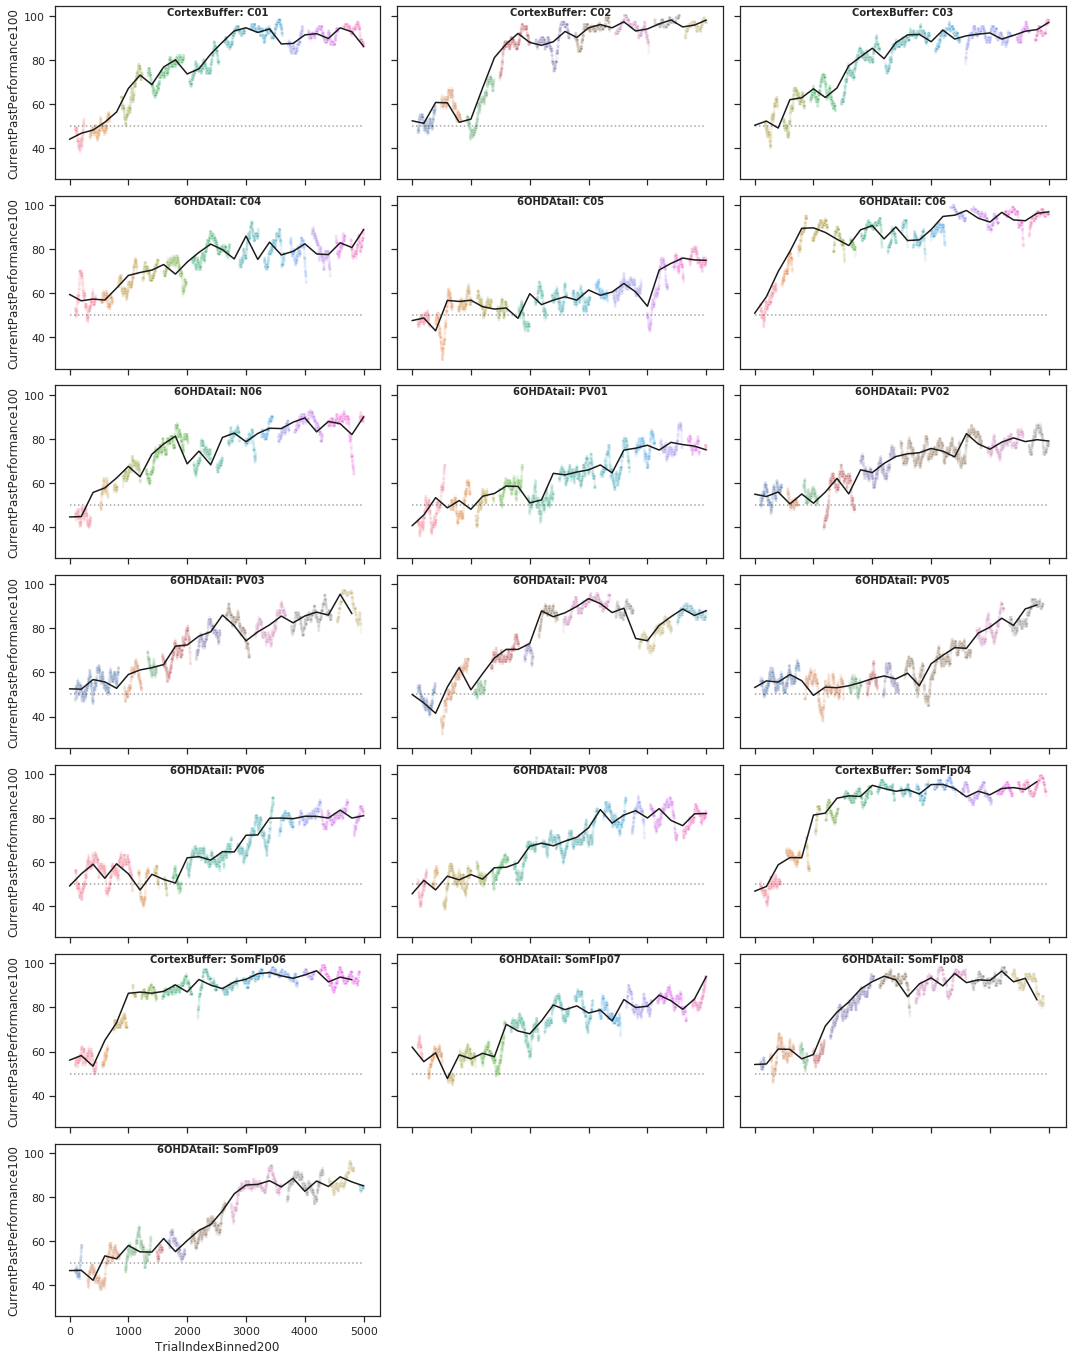

In [44]:
var_to_plot = 'CurrentPastPerformance100'
ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    
    # plot here
    sns.scatterplot(data=df_to_plot[df_to_plot.AnimalID == animal],
                x="CumulativeTrialNumberByProtocol",
                y=var_to_plot,
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    # plot a line for binned trials
    sns.lineplot(data=df_to_plot[df_to_plot.AnimalID == animal],
                 x="TrialIndexBinned200",
                 y=var_to_plot,
                 color='k',
                 ci=None,
                 ax=ax)
    
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
update_progress(1)
plt.savefig(data_directory + var_to_plot + '_individual_animals.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [45]:
df_to_plot[df_to_plot.AnimalID=='C01'].dropna()

,AnimalID,CenterPortDuration,Contingency,CumulativePerformance,ExperimentalGroup,FirstPoke,FirstPokeCorrect,FullSessionTime,Muscimol,OptoStim,...,CumulativeTrialNumberByProtocol,CurrentPastPerformance20,CurrentPastPerformance100,NoOfCenterPokes,MiddleWaitTime,TrialInitiationTime,TrialsSpeed,PrevTrialSuccess,TrialIndexBinned200,TrialIndexBinned30


In [46]:
# groupby so each animal has a mean of the performance in each bin
df_bintr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned30','Protocol']).median().reset_index()

In [47]:
df_bintr[df_bintr.AnimalID=='C01']

,AnimalID,ExperimentalGroup,TrialIndexBinned30,Protocol,CenterPortDuration,Contingency,CumulativePerformance,FirstPoke,FirstPokeCorrect,OptoStim,...,CumulativeTrialNumber,CumulativeTrialNumberByProtocol,CurrentPastPerformance20,CurrentPastPerformance100,NoOfCenterPokes,MiddleWaitTime,TrialInitiationTime,TrialsSpeed,PrevTrialSuccess,TrialIndexBinned200
0,C01,CortexBuffer,0.0,Auditory,0.1,1.0,58.359133,2.0,0.0,0.0,...,3340.5,20.5,40.0,NaN,2.0,0.14150,2.74870,3.423923,0.0,0.0
1,C01,CortexBuffer,30.0,Auditory,0.1,1.0,57.142857,2.0,1.0,0.0,...,3364.5,44.5,55.0,NaN,2.0,0.14200,2.25420,9.209508,1.0,0.0
2,C01,CortexBuffer,60.0,Auditory,0.1,1.0,53.378995,1.0,0.0,0.0,...,3394.5,74.5,45.0,NaN,2.0,0.11590,2.37010,9.321035,0.0,0.0
3,C01,CortexBuffer,90.0,Auditory,0.1,1.0,51.649148,1.0,0.0,0.0,...,3424.5,104.5,45.0,48.0,3.0,0.11510,2.23120,10.607701,0.0,0.0
4,C01,CortexBuffer,120.0,Auditory,0.1,1.0,48.319423,2.0,0.0,0.0,...,3454.5,134.5,30.0,46.0,3.0,0.12645,2.29930,9.670172,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,C01,CortexBuffer,4860.0,Auditory,0.1,1.0,95.447142,1.0,1.0,0.0,...,8194.5,4874.5,100.0,96.0,2.0,0.12725,0.77510,26.886117,1.0,4800.0
163,C01,CortexBuffer,4890.0,Auditory,0.1,1.0,95.405809,1.0,1.0,0.0,...,8224.5,4904.5,95.0,96.0,3.0,0.12675,0.71830,28.186875,1.0,4800.0
164,C01,CortexBuffer,4920.0,Auditory,0.1,1.0,94.925387,1.0,1.0,0.0,...,8254.5,4934.5,85.0,94.0,1.0,0.13370,0.93185,20.597730,1.0,4800.0
165,C01,CortexBuffer,4950.0,Auditory,0.1,1.0,93.875050,2.0,1.0,0.0,...,8284.5,4964.5,95.0,89.0,2.0,0.12090,1.07230,31.237979,1.0,4800.0


In [48]:
df_bintr.AnimalID.unique()

array(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06', 'PV01', 'PV02',
       'PV03', 'PV04', 'PV05', 'PV06', 'PV08', 'SomFlp04', 'SomFlp06',
       'SomFlp07', 'SomFlp08', 'SomFlp09'], dtype=object)

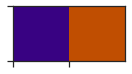

In [49]:
# set a color palette https://xkcd.com/color/rgb/
hmv_palette = ['#380282', '#c04e01']
sns.set_palette(hmv_palette)
sns.palplot(sns.color_palette())

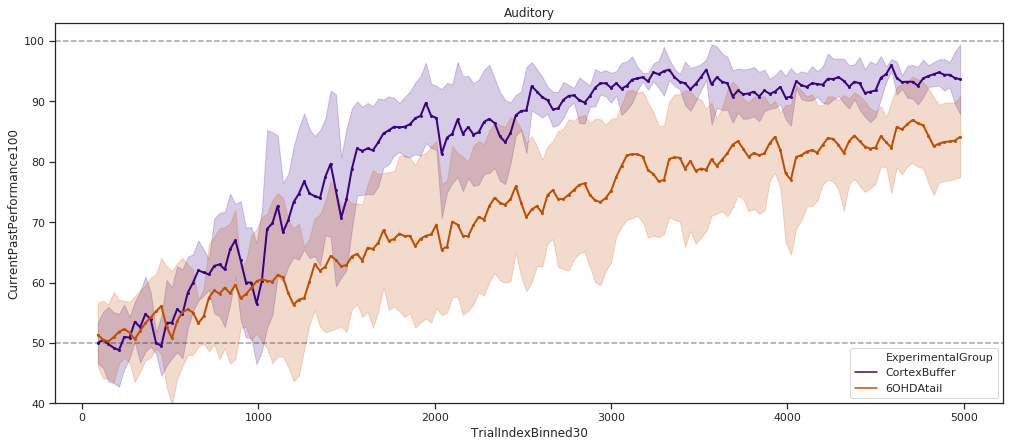

In [50]:
column_to_plot = 'CurrentPastPerformance100'

fig, axs = plt.subplots(len(pd.unique(df_bintr['Protocol'])), 1, figsize=(17,7 * len(pd.unique(df_bintr['Protocol']))), sharex=True)
if axs.numRows > 1:
    axs = axs.ravel()
else:
    axs = [axs,]
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

for ax, prot in enumerate(pd.unique(df_bintr['Protocol'])):
    sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
                 data=df_bintr[df_bintr['Protocol']==prot],
                 ax=axs[ax], hue='ExperimentalGroup',
                 hue_order=['CortexBuffer', '6OHDAtail'],
                 marker=".", alpha=1,
                 markeredgewidth=0, linewidth=2,
                 ci='sd', n_boot=10000)
                 # the following line splits the data and does not compute confidence intervals and mean
                 #units="AnimalID", estimator=None)
                
    axs[ax].set_title(prot)
    axs[ax].set_ylim(bottom=40)
    '''
    lgd = axs[ax].legend(ncol=4, loc=(0,1.05), borderaxespad=0.)
    for l in lgd.get_lines():
        l.set_alpha(1)
        l.set_linewidth(4)
    '''
for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)
        
#plt.savefig(outputDir + column_to_plot + 'ByProtocol_Grouped_AnimalSelection.pdf',
plt.savefig(data_directory + column_to_plot + 'ByProtocol_Grouped.pdf',
            transparent=True, bbox_inches='tight')
plt.show()

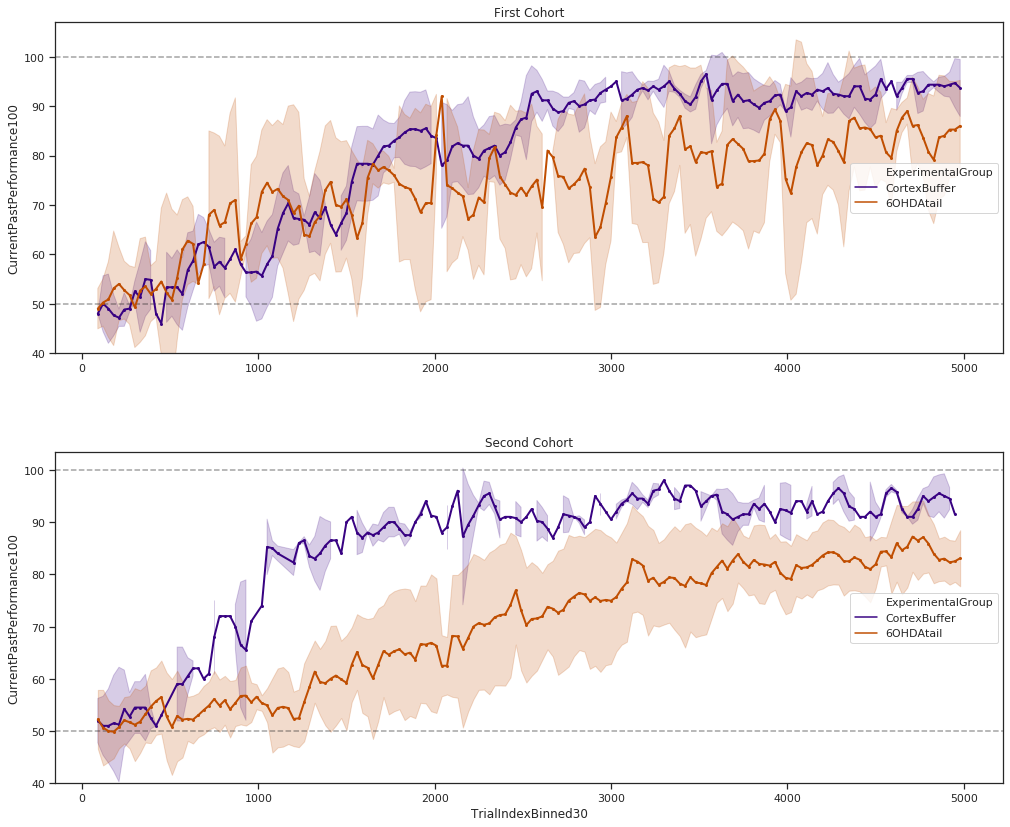

In [51]:
# test how this looks for each cohort
ans_in_first_cohort = ['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'N06']

column_to_plot = 'CurrentPastPerformance100'

fig, axs = plt.subplots(2, 1, figsize=(17, 14), sharex=True)
axs = axs.ravel()
fig.subplots_adjust(hspace = 0.3)
for ax in axs:
    ax.axhline(50, ls='--', alpha=0.4, color='k')
    ax.axhline(100, ls='--', alpha=0.4, color='k')

sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
             data=df_bintr[df_bintr.AnimalID.isin(ans_in_first_cohort)],
             ax=axs[0], hue='ExperimentalGroup',
             hue_order=['CortexBuffer', '6OHDAtail'],
             marker=".", alpha=1,
             markeredgewidth=0, linewidth=2,
             ci='sd', n_boot=10000)
             
axs[0].set_title('First Cohort')
axs[0].set_ylim(bottom=40)

sns.lineplot(x='TrialIndexBinned30', y=column_to_plot,
             data=df_bintr[~df_bintr.AnimalID.isin(ans_in_first_cohort)],
             ax=axs[1], hue='ExperimentalGroup',
             hue_order=['CortexBuffer', '6OHDAtail'],
             marker=".", alpha=1,
             markeredgewidth=0, linewidth=2,
             ci='sd', n_boot=10000)
             
axs[1].set_title('Second Cohort')
axs[1].set_ylim(bottom=40)

for ax in axs:
    ax.xaxis.set_tick_params(which='both', labelbottom=True)

plt.show()

### calculate the statistical differences of performances on a 200 trial window at different trial indexes

In [52]:
df_bin200tr = df_to_plot.groupby(['AnimalID','ExperimentalGroup','TrialIndexBinned200']).median().reset_index()[[
    'AnimalID','ExperimentalGroup','TrialIndexBinned200','CumulativePerformance','CurrentPastPerformance100']]

In [53]:
df_bin200tr

,AnimalID,ExperimentalGroup,TrialIndexBinned200,CumulativePerformance,CurrentPastPerformance100
0,C01,CortexBuffer,0.0,51.523824,43.0
1,C01,CortexBuffer,200.0,47.142857,47.0
2,C01,CortexBuffer,400.0,47.247784,48.0
3,C01,CortexBuffer,600.0,48.947028,52.0
4,C01,CortexBuffer,800.0,60.269437,56.0
...,...,...,...,...,...
488,SomFlp09,6OHDAtail,4200.0,85.348506,87.5
489,SomFlp09,6OHDAtail,4400.0,87.173814,85.0
490,SomFlp09,6OHDAtail,4600.0,87.228814,89.0
491,SomFlp09,6OHDAtail,4800.0,84.955752,85.0


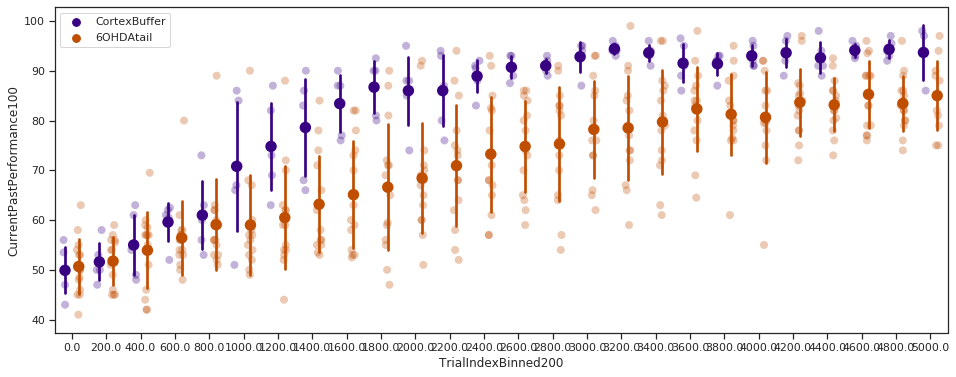

In [54]:
tr_to_show = [200, 600, 1000, 1400, 2000, 3000, 4000, 4800]
df_st = df_bin200tr[df_bin200tr.TrialIndexBinned200.isin(tr_to_show)]
df_st = df_bin200tr
plt.figure(figsize=(16, 6))

# add mean and sd
sns.pointplot(data=df_st,
              x='TrialIndexBinned200',
              y='CurrentPastPerformance100',
              hue='ExperimentalGroup',
              dodge=.4, join=False,
              markers="o", scale=1.3, ci='sd')

sns.stripplot(data=df_st,
            x='TrialIndexBinned200',
            y='CurrentPastPerformance100',
            hue='ExperimentalGroup',
            dodge=True, jitter=.15,
            alpha=.3, zorder=1, size=8)

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.show()

In [55]:
# perform the tests
for index, group in df_st.groupby('TrialIndexBinned200'):
    kt = stats.kruskal(group[group.ExperimentalGroup=='CortexBuffer'].CurrentPastPerformance100,
              group[group.ExperimentalGroup=='6OHDAtail'].CurrentPastPerformance100)
    print('Trial: ' + str(index) + '\t\tpvalue: ' + str(kt.pvalue) )

Trial: 0.0		pvalue: 0.9260413083248457
Trial: 200.0		pvalue: 0.9260087707689554
Trial: 400.0		pvalue: 0.7097977398525406
Trial: 600.0		pvalue: 0.08606404814464876
Trial: 800.0		pvalue: 0.3755306383881257
Trial: 1000.0		pvalue: 0.1509222265293295
Trial: 1200.0		pvalue: 0.018030362419293382
Trial: 1400.0		pvalue: 0.018081068750948982
Trial: 1600.0		pvalue: 0.007179146324530832
Trial: 1800.0		pvalue: 0.008155619216658782
Trial: 2000.0		pvalue: 0.014023618285547308
Trial: 2200.0		pvalue: 0.023192323821689058
Trial: 2400.0		pvalue: 0.018081068750948982
Trial: 2600.0		pvalue: 0.001181883551709746
Trial: 2800.0		pvalue: 0.004055321211930086
Trial: 3000.0		pvalue: 0.0039907164442741045
Trial: 3200.0		pvalue: 0.005437566051275805
Trial: 3400.0		pvalue: 0.015846645830908567
Trial: 3600.0		pvalue: 0.0260881088242533
Trial: 3800.0		pvalue: 0.015754366941574845
Trial: 4000.0		pvalue: 0.00533584168580549
Trial: 4200.0		pvalue: 0.012314210885589651
Trial: 4400.0		pvalue: 0.005356101535232455
Trial: 4

In [56]:
stats.kruskal(df_bin200tr[df_bin200tr.ExperimentalGroup=='CortexBuffer'].CurrentPastPerformance100.dropna(),
              df_bin200tr[df_bin200tr.ExperimentalGroup=='6OHDAtail'].CurrentPastPerformance100.dropna())

KruskalResult(statistic=59.704282735437964, pvalue=1.1023639422612049e-14)

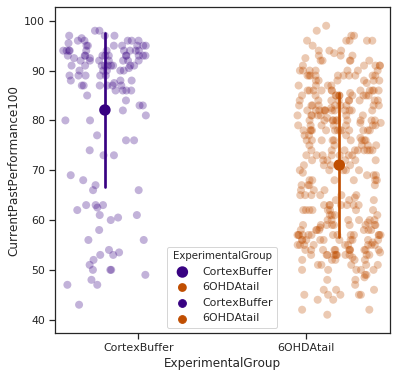

In [57]:
df_st = df_bin200tr
plt.figure(figsize=(6, 6))

# add mean and sd
sns.pointplot(data=df_st,
              x='ExperimentalGroup',
              y='CurrentPastPerformance100',
              hue='ExperimentalGroup',
              dodge=.4, join=False,
              markers="o", scale=1.3, ci='sd')

sns.stripplot(data=df_st,
            x='ExperimentalGroup',
            y='CurrentPastPerformance100',
            hue='ExperimentalGroup',
            dodge=True, jitter=.5,
            alpha=.3, zorder=1, size=8)

In [58]:
import pingouin as pg
aov = pg.rm_anova(dv='CurrentPastPerformance100', within='TrialIndexBinned200',
                   subject='ExperimentalGroup', data=df_bin200tr, detailed=True)
print(aov)

                Source        SS  DF       MS       F        p-unc   np2   eps
0  TrialIndexBinned200  8240.902  25  329.636  19.072  8.04567e-11  0.95  0.04
1                Error   432.106  25   17.284       -            -     -     -


#### Fit a curve and calculate stages and learning rates

Progress: [###################-] 94.7%


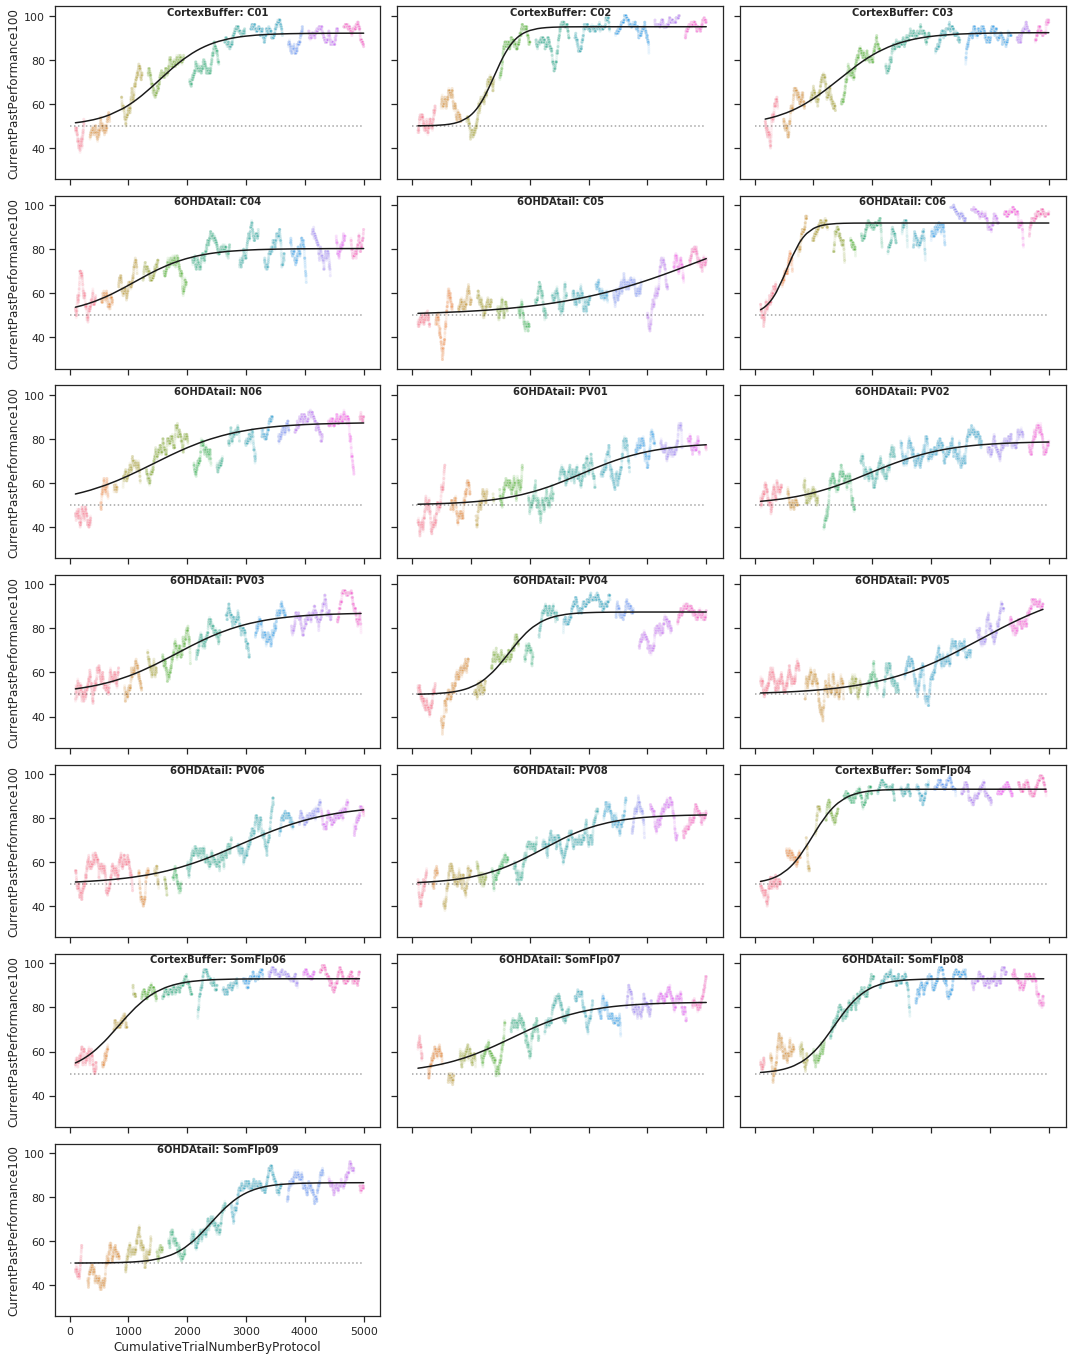

In [81]:
def sigmoid_func(x, perf_end, slope, bias): 
    return (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5 


ans_list = np.sort(df_to_plot.AnimalID.unique())
num_ans = len(ans_list)
# create a diccionary to store the results, and lists to rescale the data
fit_dir = {}
xmeans_list = []
xsd_list = []

fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # plot here
    sns.scatterplot(data=df,
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    # calculate and plot the fitting
    xdata = np.array(df.CumulativeTrialNumberByProtocol)
    ydata = np.array(df.CurrentPastPerformance100)
    
    # scale the data
    xdatasc = (xdata - xdata.mean()) / xdata.std()
    ydatasc = ydata / 100

    cost_func = lambda x: np.mean(np.abs(sigmoid_func(xdatasc, x[0], x[1], x[2]) - ydatasc))
    res = opt.minimize(cost_func, [1, 0, 0], bounds=((0.5, 1.0), (0., 10.), (None,None)))
    
    # predict the data and rescale it back
    ypredscb = 100 * sigmoid_func(xdatasc, *res.x)

    sns.lineplot(x=xdata,
                 y=ypredscb,
                 color='k',
                 ci=None,
                 ax=ax)
    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
    #update dicctionary and lists
    fit_dir[animal] = res
    xmeans_list.append(xdata.mean())
    xsd_list.append(xdata.std())
    
plt.show()

In [82]:
for key, value in fit_dir.items():
    print(key,  '  ', value.x)

C01    [ 0.92086788  3.27783165 -0.76669101]
C02    [ 0.9500007   7.52559068 -0.83072567]
C03    [ 0.92328324  2.77617324 -0.84415492]
C04    [ 0.80354822  2.76986545 -0.99803238]
C05    [1.         1.18589689 1.59379455]
C06    [ 0.91930615  8.92780668 -1.42604433]
N06    [ 0.87423946  2.00663682 -0.8246288 ]
PV01    [0.7825388  2.22699917 0.259737  ]
PV02    [ 0.78844315  2.11403932 -0.47587757]
PV03    [ 0.87075453  2.19030782 -0.50259713]
PV04    [ 0.87422843  5.22530591 -0.66609838]
PV05    [1.         1.63097552 0.92394258]
PV06    [0.85855784 1.88222033 0.24261129]
PV08    [ 0.81548143  2.52063286 -0.29586198]
SomFlp04    [ 0.93009404  5.80467877 -1.1395827 ]
SomFlp06    [ 0.93011296  4.03490721 -1.25298057]
SomFlp07    [ 0.82425242  2.19188219 -0.67321212]
SomFlp08    [ 0.93000278  4.84039436 -0.92020275]
SomFlp09    [ 0.86475144  4.48508724 -0.12436177]


In [83]:
# convert to dataframe
fit_df = pd.DataFrame({
    'AnimalID': list(fit_dir.keys()),
    'maximum_performance': [v.x[0] for k, v in fit_dir.items()],
    'slope': [v.x[1] for k, v in fit_dir.items()],
    'bias': [v.x[2] for k, v in fit_dir.items()]
})
# get the Experimental procedure
fit_df['ExperimentalGroup'] = fit_df['AnimalID'].apply(
        lambda x: df_to_plot[df_to_plot.AnimalID==x].ExperimentalGroup.unique()[0]
    )
# rescale back the coefficients
fit_df.maximum_performance = fit_df.maximum_performance * 100
fit_df.slope = fit_df.slope / np.array(xsd_list)
fit_df.bias = fit_df.bias * np.array(xsd_list) + np.array(xmeans_list)

In [84]:
fit_df

,AnimalID,maximum_performance,slope,bias,ExperimentalGroup
0,C01,92.086788,0.002335,1535.838399,CortexBuffer
1,C02,95.000070,0.005318,1393.323649,CortexBuffer
2,C03,92.328324,0.002026,1434.868136,CortexBuffer
3,C04,80.354822,0.001956,1103.480261,6OHDAtail
4,C05,100.000000,0.000818,4922.934784,6OHDAtail
5,C06,91.930615,0.006099,547.311655,6OHDAtail
6,N06,87.423946,0.001418,1422.847301,6OHDAtail
7,PV01,78.253880,0.001592,2877.050376,6OHDAtail
8,PV02,78.844315,0.001514,1949.674851,6OHDAtail
9,PV03,87.075453,0.001520,1814.754490,6OHDAtail


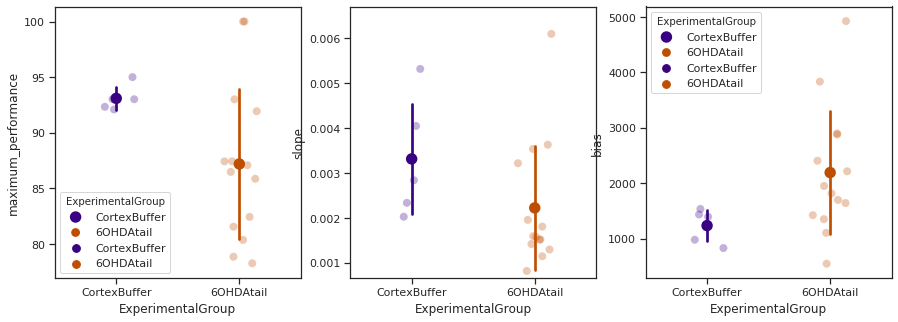

In [85]:
fig, axs = plt.subplots(ncols=3, sharey=False, figsize=(15,5))
axs = axs.ravel()
for i, var in enumerate(['maximum_performance', 'slope', 'bias']):
    sns.pointplot(data=fit_df,
                x='ExperimentalGroup',
                y=var,
                hue='ExperimentalGroup',
                dodge=False, join=False,
                markers="o", scale=1.3, ci='sd',
                ax=axs[i])
    
    sns.stripplot(data=fit_df,
                x='ExperimentalGroup',
                y=var,
                hue='ExperimentalGroup',
                dodge=False, jitter=.15,
                alpha=.3, zorder=1, size=8,
                ax=axs[i])



#ax2.legend(bbox_to_anchor=(1.23, 1), loc=0, borderaxespad=0.)
axs[1].set_ylim(0.8 * np.min(fit_df.slope), 1.1 * np.max(fit_df.slope))
axs[1].get_legend().remove()


In [64]:
for var in ['maximum_performance', 'slope', 'bias']:
    kt = stats.kruskal(fit_df[fit_df.ExperimentalGroup=='CortexBuffer'][var].dropna(),
                  fit_df[fit_df.ExperimentalGroup=='6OHDAtail'][var].dropna())
    print(var + ':\t\tpvalue: ' + str(kt.pvalue) )

maximum_performance:		pvalue: 0.033145138648116475
slope:		pvalue: 0.05186866065193848
bias:		pvalue: 0.041669665306969965


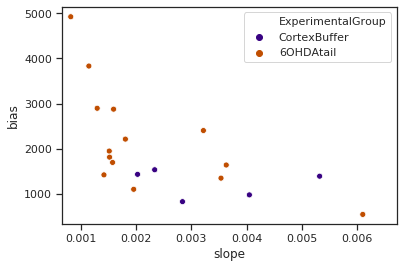

In [65]:
sns.scatterplot(data=fit_df,
               x='slope',
               y='bias',
               hue='ExperimentalGroup')
plt.gca().set_xlim(0.8 * np.min(fit_df.slope), 1.1 * np.max(fit_df.slope))
plt.show()

In [ ]:
# explore another way of calculating the learning rate (e.g. maximum of the derivative) and the bias (e.g. learning period
# extracted from percentages of the sigmoid)

In [86]:
# sigmoid function scaled
def sigmoid_func_sc(x, perf_end, slope, bias): 
    return (perf_end - 50) / (1 + np.exp(-slope * (x - bias))) + 50

Progress: [###################-] 94.7%


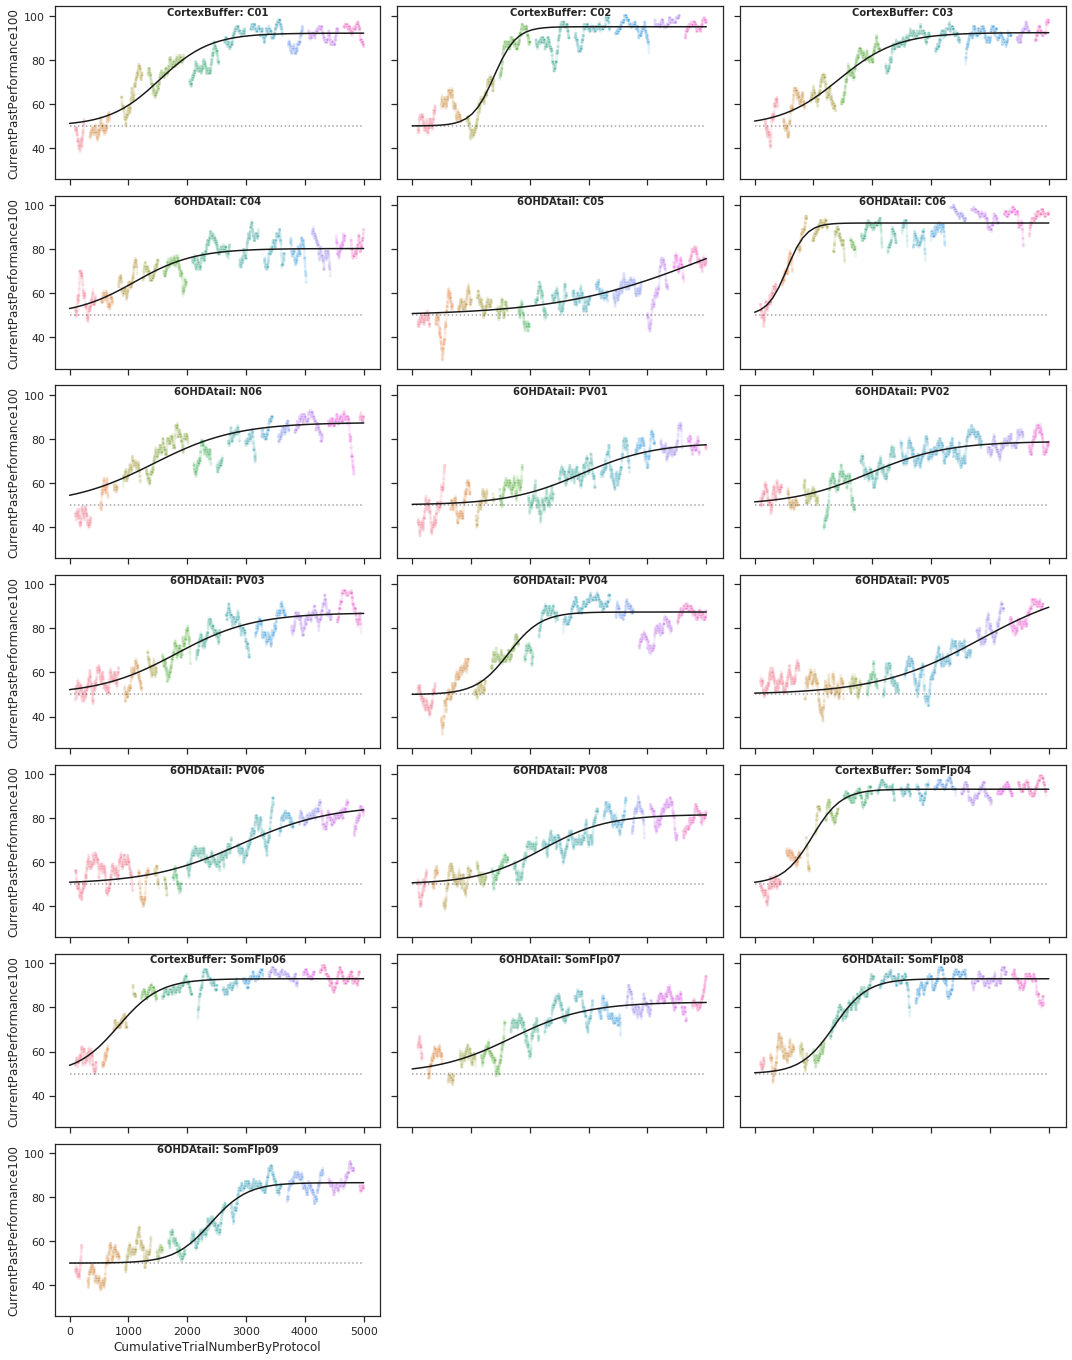

In [133]:
# sanity check to see that these scaled values recreate the curves

x = np.linspace(1,5000)

fig, axs = plt.subplots(math.ceil(num_ans/3), 3,
                        figsize=(15, num_ans),
                        facecolor='w', edgecolor='k', sharey=True, sharex=True)
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for i, ax in enumerate(axs):
    if i < num_ans:
        ax.hlines(50, 0, 5000, linestyles='dotted', alpha=0.4)
    ax.axis('off')
# process data from all animals
for counter, animal in enumerate(ans_list):
    ax = axs[counter]
    df = df_to_plot[df_to_plot.AnimalID==animal][
        ['CumulativeTrialNumberByProtocol',
         'CurrentPastPerformance100',
         'SessionID']
    ].dropna()
    
    # plot here
    sns.scatterplot(data=df,
                x="CumulativeTrialNumberByProtocol",
                y='CurrentPastPerformance100',
                marker='.',
                hue='SessionID',
                alpha=.1,
                ax=ax)
    
    sns.lineplot(x=x,
                 y=sigmoid_func_sc(x, *[fit_df[fit_df.AnimalID==animal].maximum_performance.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].slope.iloc[0],
                                        fit_df[fit_df.AnimalID==animal].bias.iloc[0]]),
                 color='k',
                 ci=None,
                 ax=ax)

    
    ax.get_legend().remove()
    ec = df_to_plot[df_to_plot.AnimalID == animal].ExperimentalGroup.unique()[0]
    ax.text(.5,.95, ec + ': ' + animal, horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

    ax.axis('on')

    plt.tight_layout()

    update_progress(counter / num_ans)
    
plt.show()

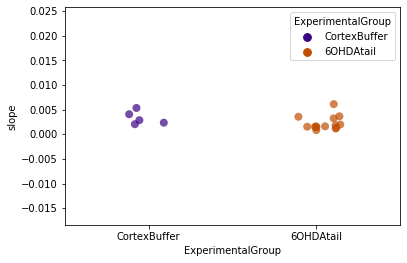

In [44]:
sns.stripplot(data=fit_df,
            x='ExperimentalGroup',
            y='slope',
            hue='ExperimentalGroup',
            dodge=False, jitter=.15,
            alpha=.7, zorder=1, size=8)

In [374]:
dset = pd.DataFrame({'idx': np.repeat(np.arange(3), 10), 'values': np.random.randn(30), 'groups': np.arange(30) % 2})
print(dset)
dset.groupby('idx').apply(lambda x: x.loc[x.groups == 0, 'values'].mean() - x.loc[x.groups == 1, 'values'].mean())

    idx    values  groups
0     0 -0.546946       0
1     0 -1.080070       1
2     0 -0.367109       0
3     0 -1.333966       1
4     0 -0.416050       0
5     0  0.160385       1
6     0 -0.228677       0
7     0 -0.160157       1
8     0  1.033434       0
9     0  0.112552       1
10    1  0.627697       0
11    1  0.107692       1
12    1 -0.635439       0
13    1  0.062638       1
14    1  0.144883       0
15    1  0.076086       1
16    1 -1.756503       0
17    1 -1.131852       1
18    1  0.561801       0
19    1  1.402525       1
20    2 -0.275472       0
21    2  0.351997       1
22    2 -1.565531       0
23    2 -1.750205       1
24    2 -0.367330       0
25    2  0.676172       1
26    2  1.337307       0
27    2 -0.276384       1
28    2 -0.772895       0
29    2 -0.820609       1


idx
0    0.355182
1   -0.314930
2    0.035022
dtype: float64

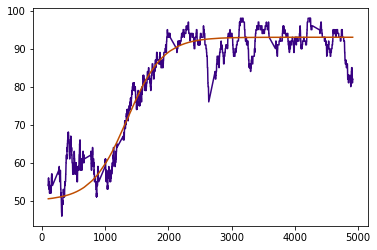

In [346]:
test = df_to_plot[df_to_plot.AnimalID=='SomFlp08'][['CumulativeTrialNumberByProtocol', 'CurrentPastPerformance100']].dropna()


def sigmoid_func(x, perf_end, slope, bias): 
    return (perf_end - 0.5) / (1 + np.exp(-slope * x + bias)) + 0.5 

xdata = np.array(test.CumulativeTrialNumberByProtocol)
xdatasc = (xdata - xdata.mean()) / xdata.std()
ydata = np.array(test.CurrentPastPerformance100)
ydatasc = ydata / 100

cost_func = lambda x: np.mean(np.abs(sigmoid_func(xdatasc, x[0], x[1], x[2]) - ydatasc))
res = opt.minimize(cost_func, [1, 0, 0])

ypredscb = 100 * sigmoid_func(xdatasc, *res.x)

plt.plot(xdata, ydata)
plt.plot(xdata, ypredscb)

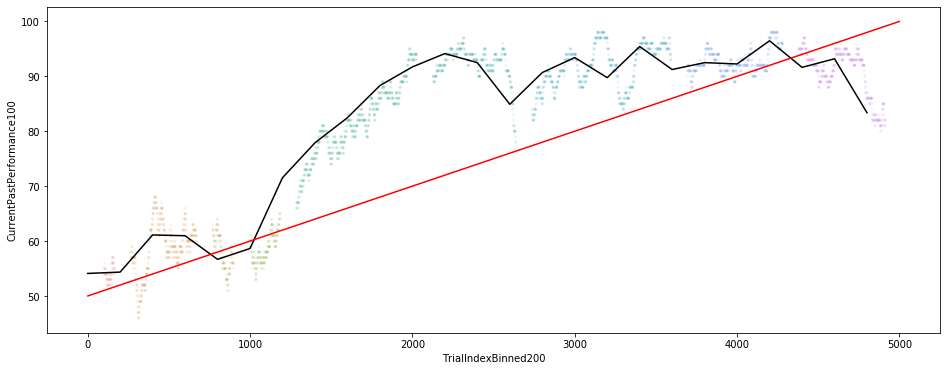

In [176]:
plt.figure(figsize=(16, 6))
# plot here
sns.scatterplot(data=test,
            x="CumulativeTrialNumberByProtocol",
            y='CurrentPastPerformance100',
            marker='.',
            hue='SessionID',
            alpha=.1)

# plot a line for binned trials
sns.lineplot(data=test,
             x="TrialIndexBinned200",
             y='CurrentPastPerformance100',
             color='k',
             ci=None)

x=np.array(range(1,5000))
plt.plot(x, x/100 + 50, color='red')

plt.gca().get_legend().remove()
plt.show()

[ 0.92407522  4.07276332 -0.95582449]


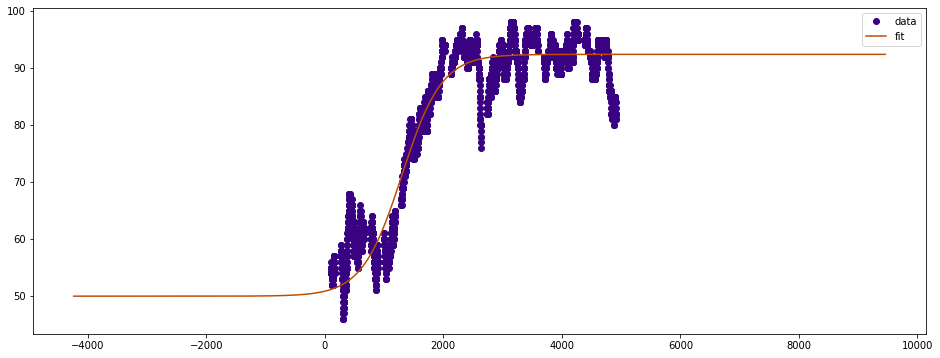

In [345]:
from scipy.optimize import curve_fit
def sigmoid_func(x, perf_end, slope, bias):
    return (perf_end - 0.5) / (1 + np.exp(-slope * (x - bias))) + 0.5

xdata = np.array(test.CumulativeTrialNumberByProtocol)
xdatasc = (xdata - xdata.mean()) / xdata.std()
ydata = np.array(test.CurrentPastPerformance100)
ydatasc = ydata / 100

popt, pcov = curve_fit(sigmoid_func, xdatasc, ydatasc)
print(popt)

xpred = np.linspace(-5,5,1000)
ypred = sigmoid_func(xpred, *popt)

xpredscb = xpred * xdata.std() + xdata.mean()
ypredscb = 100 * ypred

plt.figure(figsize=(16, 6))
plt.plot(xdata, ydata, 'o', label='data')
plt.plot(xpredscb, ypredscb, label='fit')
plt.legend(loc='best')
plt.show()